In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_california_housing, load_diabetes, load_iris, load_wine

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, accuracy_score

from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Activation, Dropout
from keras.optimizers import Adam
import itertools

from tqdm import tqdm

In [3]:
california_housing = fetch_california_housing()
diabetes = load_diabetes()
iris = load_iris()
wine = load_wine()

datasets = {
  'CaliforniaHousing': pd.DataFrame(
    data=np.c_[california_housing['data'], california_housing['target']],
    columns=california_housing['feature_names'] + ['target']
  ),
  'Diabetes': pd.DataFrame(
    data=np.c_[diabetes['data'], diabetes['target']],
    columns=diabetes['feature_names'] + ['target']
  ),
  'Iris': pd.DataFrame(
    data=np.c_[iris['data'], iris['target']],
    columns=iris['feature_names'] + ['target']
  ),
  'Wine': pd.DataFrame(
    data=np.c_[wine['data'], wine['target']],
    columns=wine['feature_names'] + ['target']
  ),
}

In [4]:
def build_regression_model(input_dim, use_batch_norm):
  model = Sequential()

  model.add(Dense(64, input_dim=input_dim))
  if use_batch_norm:
    model.add(BatchNormalization(momentum=0.01))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
    
  model.add(Dense(32))
  if use_batch_norm:
    model.add(BatchNormalization(momentum=0.01))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))

  model.add(Dense(1))

  model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

  return model

def build_classification_model(input_dim, num_classes, use_batch_norm):
  model = Sequential()

  model.add(Dense(64, input_dim=input_dim))
  if use_batch_norm:
    model.add(BatchNormalization(momentum=0.01))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))

  model.add(Dense(32))
  if use_batch_norm:
    model.add(BatchNormalization(momentum=0.01))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))

  model.add(Dense(num_classes))
  if use_batch_norm:
    model.add(BatchNormalization(momentum=0.01))
  model.add(Activation('softmax'))

  model.compile(optimizer=Adam(learning_rate=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  return model

In [5]:
def evaluate_model(model, X_train, X_test, y_train, y_test, task_type):
  model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

  y_pred = model.predict(X_test)

  if task_type == 'regression':
    return mean_squared_error(y_test, y_pred)
  elif task_type == 'classification':
    y_pred_classes = np.argmax(y_pred, axis=1)
    return accuracy_score(y_test, y_pred_classes)

In [6]:
normalizations = {
  'None': lambda x: x,
  'MinMax': MinMaxScaler(),
  'Standard': StandardScaler(),
}

In [7]:
results = []

for dataset_name, df in tqdm(datasets.items()):
  X = df.drop(columns=['target']).values
  y = df['target'].values
  task_type = 'regression' if dataset_name in ['CaliforniaHousing', 'Diabetes'] else 'classification'
  input_dim = X.shape[1]
  num_classes = len(np.unique(y)) if task_type == 'classification' else None

  for norm_name, norm in normalizations.items():
    if norm_name != "None":
      X_norm = norm.fit_transform(X)
    else:
      X_norm = X

    X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.2, random_state=42)

    for batch_norm in [True, False]:
      if task_type == 'regression':
        model = build_regression_model(input_dim, batch_norm)
      else:
        model = build_classification_model(input_dim, num_classes, batch_norm)

      metric = evaluate_model(model, X_train, X_test, y_train, y_test, task_type)
      results.append({
        'Dataset': dataset_name,
        'Normalization': norm_name,
        'BatchNormalization': batch_norm,
        'Metric': metric,
      })

  0%|          | 0/4 [00:00<?, ?it/s]2024-09-23 15:24:37.986735: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13944 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:8c:00.0, compute capability: 7.5


129/129 [==============================] - 0s 923us/step


 25%|██▌       | 1/4 [03:39<10:59, 219.94s/it]

3/3 [==============================] - 0s 2ms/step


 50%|█████     | 2/4 [03:51<03:14, 97.13s/it] 

1/1 [==============================] - 0s 50ms/step


 75%|███████▌  | 3/4 [03:59<00:56, 56.52s/it]

2/2 [==============================] - 0s 4ms/step


100%|██████████| 4/4 [04:07<00:00, 61.92s/it]


In [8]:
results_df = pd.DataFrame(results)
results_df

,Dataset,Normalization,BatchNormalization,Metric
0,CaliforniaHousing,None,True,5.307281e-01
1,CaliforniaHousing,None,False,1.310553e+00
2,CaliforniaHousing,MinMax,True,4.424578e-01
3,CaliforniaHousing,MinMax,False,5.261585e-01
4,CaliforniaHousing,Standard,True,4.528302e-01
5,CaliforniaHousing,Standard,False,4.499310e-01
6,Diabetes,None,True,1.519937e+06
7,Diabetes,None,False,3.566945e+03
8,Diabetes,MinMax,True,1.392681e+07
9,Diabetes,MinMax,False,2.887843e+03


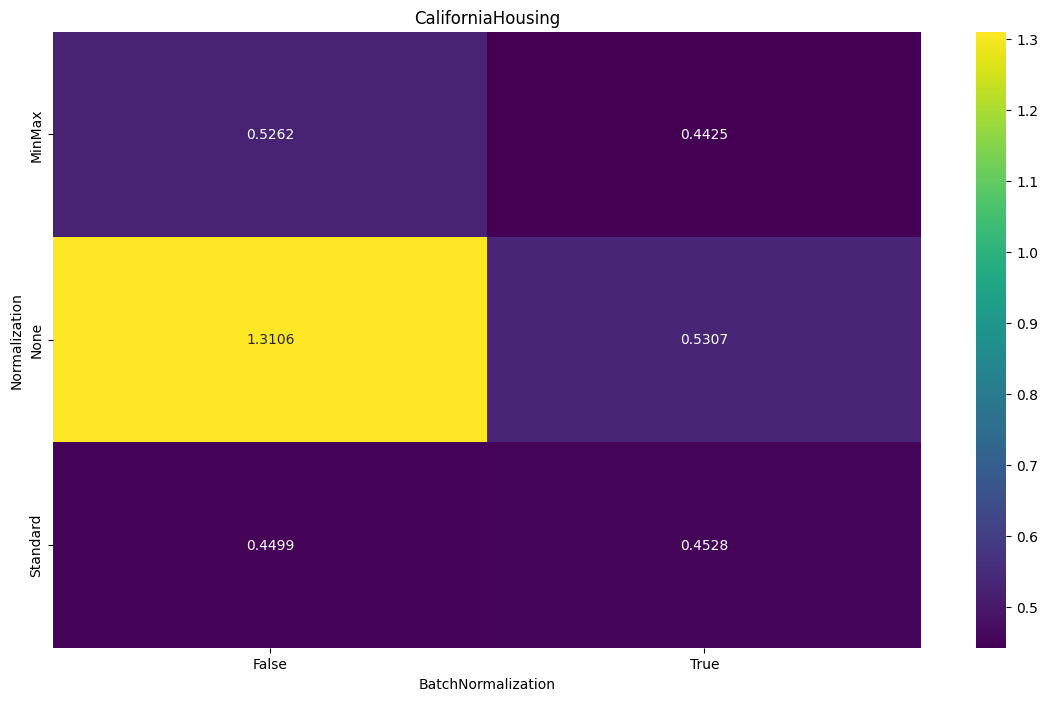

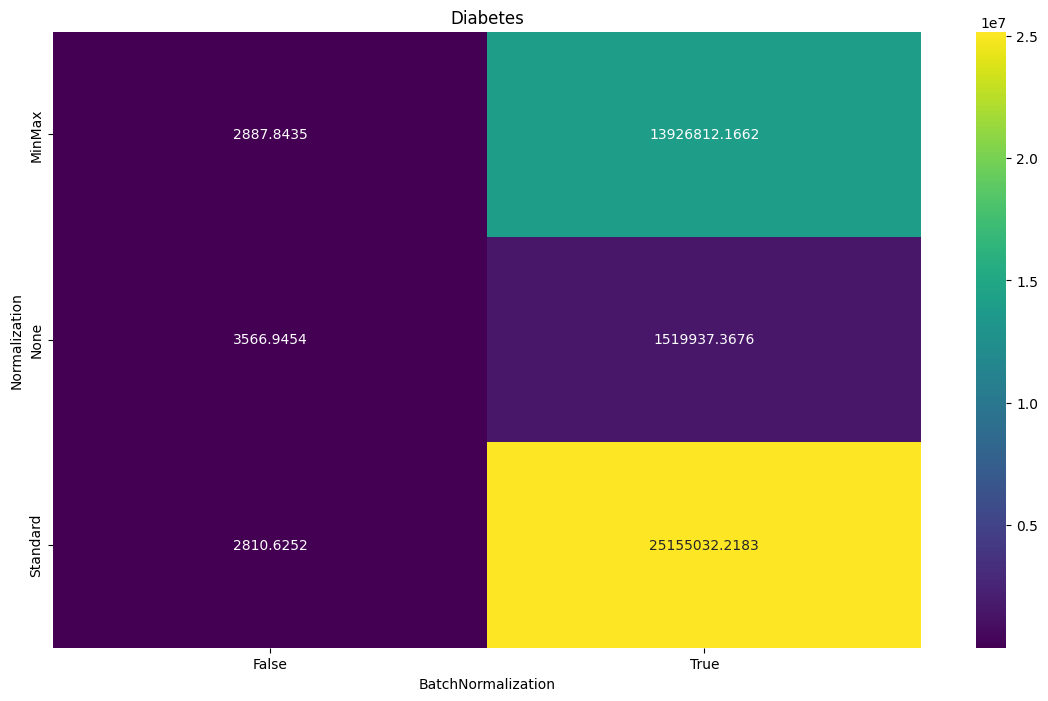

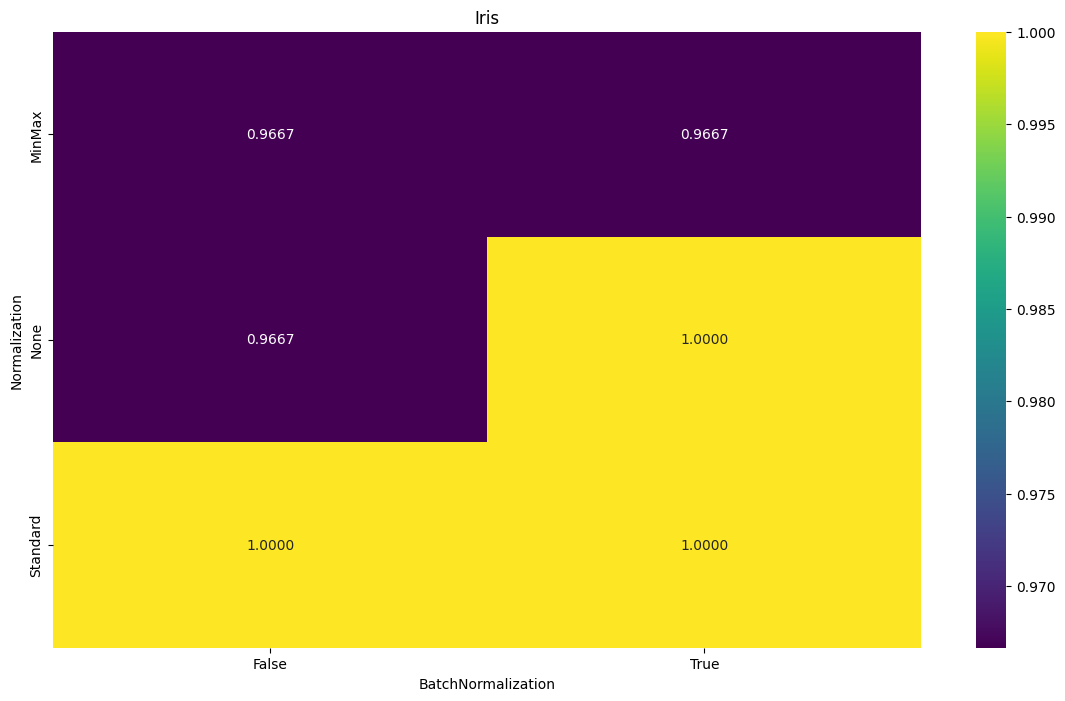

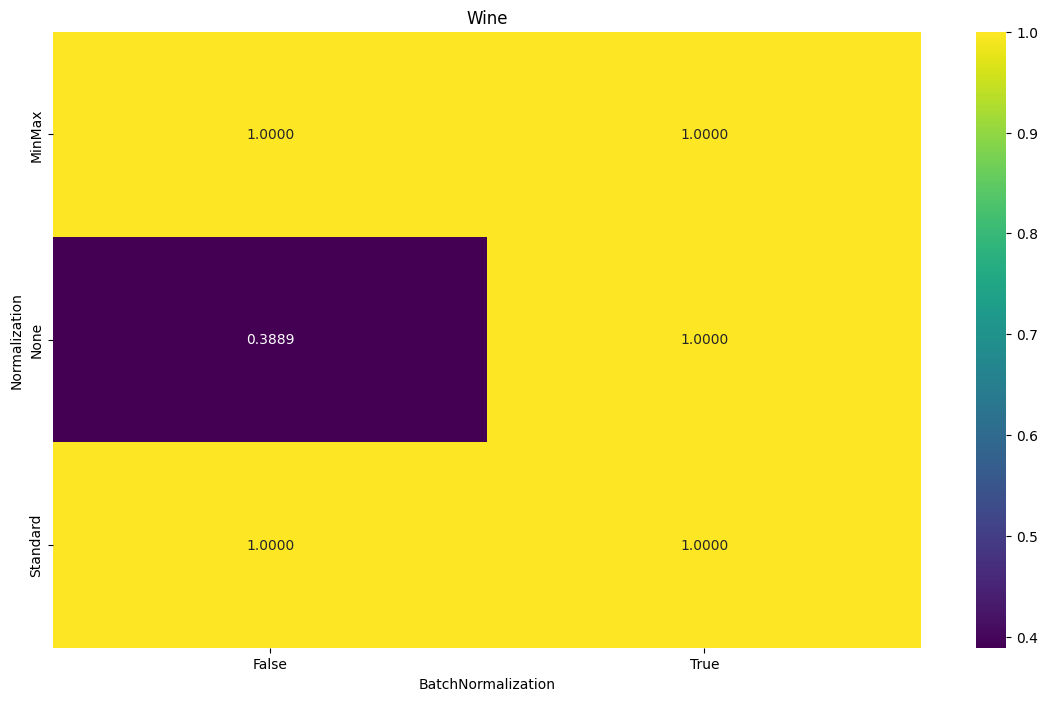

In [15]:
for dataset_name in datasets.keys():
    pivot_table = results_df[results_df['Dataset'] == dataset_name].pivot_table(index=['Normalization'], columns='BatchNormalization', values='Metric')

    # Plot the heatmap
    plt.figure(figsize=(14, 8))
    sns.heatmap(pivot_table, annot=True, fmt=".4f", cmap="viridis")
    plt.title(dataset_name)
    plt.show()